# **TRM**: Tiny Recursive Model

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
import pandas as pd
import math
import os
from pathlib import Path
from typing import Optional
from dataclasses import dataclass
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

print(f"PyTorch Version: {torch.__version__}")
print(f"CUDA Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA Device: {torch.cuda.get_device_name(0)}")
    print(f"CUDA Version: {torch.version.cuda}")


PyTorch Version: 2.9.1
CUDA Available: False


In [2]:
@dataclass
class TRMConfig:
    input_dim: int = 81 * 10
    hidden_dim: int = 512
    output_dim: int = 81 * 9
    L_layers: int = 4
    H_cycles: int = 6
    L_cycles: int = 6
    dropout: float = 0.0

    batch_size: int = 64
    epochs: int = 50
    lr: float = 1e-4
    weight_decay: float = 0.001
    train_split: float = 0.95

    data_path: str = "data/sudoku.csv"
    max_samples: Optional[int] = 100000

    save_dir: str = "checkpoints/"
    model_name: str = "trm_sudoku_best.pt"

    device: str = "cuda" if torch.cuda.is_available() else "cpu"

config = TRMConfig()
print(f"\nConfiguration:")
print(f"  Device: {config.device}")
print(f"  Batch Size: {config.batch_size}")
print(f"  Epochs: {config.epochs}")
print(f"  Learning Rate: {config.lr}")
print(f"  H_cycles: {config.H_cycles}, L_cycles: {config.L_cycles}")



Configuration:
  Device: cpu
  Batch Size: 64
  Epochs: 50
  Learning Rate: 0.0001
  H_cycles: 6, L_cycles: 6


In [3]:
class ResidualBlock(nn.Module):
    def __init__(self, dim: int, dropout: float = 0.1):
        super().__init__()
        self.net = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, dim * 4),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(dim * 4, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        return self.net(x)


class TinyRecursiveModel(nn.Module):
    def __init__(self, config: TRMConfig):
        super().__init__()
        self.config = config

        self.input_proj = nn.Linear(config.input_dim, config.hidden_dim)

        self.latent_layers = nn.ModuleList([
            ResidualBlock(config.hidden_dim, config.dropout)
            for _ in range(config.L_layers)
        ])

        self.output_layers = nn.ModuleList([
            ResidualBlock(config.hidden_dim, config.dropout)
            for _ in range(2)
        ])

        self.output_proj = nn.Linear(config.hidden_dim, config.output_dim)

        self.latent_gate = nn.Parameter(torch.tensor(0.0))
        self.output_gate = nn.Parameter(torch.tensor(0.0))

    def latent_recursion(self, x, y, z):
        combined = x + y + z
        gate = torch.sigmoid(self.latent_gate)
        for layer in self.latent_layers:
            combined = combined + gate * layer(combined)
        return combined

    def output_refinement(self, y, z):
        combined = y + z
        for layer in self.output_layers:
            gate = torch.sigmoid(self.output_gate)
            combined = combined + gate * layer(combined)
        return combined

    def forward(self, x):
        x_embedded = self.input_proj(x)
        x_embedded = x_embedded.unsqueeze(1)

        

        y = x_embedded.clone()
        z = x_embedded.clone()

        z = self.latent_recursion(x_embedded, y, z)

        y = self.output_refinement(y, z)

        for _ in range(self.config.H_cycles):
            z = self.latent_recursion(x_embedded, y, z)
            y = self.output_refinement(y, z)

        output = self.output_proj(y.squeeze(1))
        return output

    def get_num_params(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

In [4]:
class SudokuDataset(Dataset):
    def __init__(self, csv_path: str, max_samples: Optional[int] = None):
        print(f"Loading Sudoku data from {csv_path}...")

        df = pd.read_csv(csv_path)

        if max_samples:
            df = df.head(max_samples)

        print(f"Loaded {len(df)} puzzles")

        self.quizzes = []
        self.solutions = []

        for idx, row in tqdm(df.iterrows(), total=len(df), desc="Parsing data"):
            quiz = np.array([int(c) for c in row['quizzes']], dtype=np.int32)
            solution = np.array([int(c) for c in row['solutions']], dtype=np.int32)

            self.quizzes.append(quiz)
            self.solutions.append(solution)

        self.quizzes = np.array(self.quizzes)
        self.solutions = np.array(self.solutions)

        print(f"Quizzes shape: {self.quizzes.shape}")
        print(f"Solutions shape: {self.solutions.shape}")

    def __len__(self):
        return len(self.quizzes)

    def __getitem__(self, idx):
        quiz = self.quizzes[idx]
        solution = self.solutions[idx]

        quiz_onehot = np.zeros((81, 10), dtype=np.float32)
        for i, val in enumerate(quiz):
            quiz_onehot[i, val] = 1.0
        quiz_onehot = quiz_onehot.flatten()

        target = solution - 1

        return torch.FloatTensor(quiz_onehot), torch.LongTensor(target)



In [5]:
class TRMTrainer:
    def __init__(self, model: TinyRecursiveModel, config: TRMConfig):
        self.model = model.to(config.device)
        self.config = config
        self.constraint_weight = 0.1

        decay, no_decay = [], []
        for name, param in model.named_parameters():
            if param.ndim == 1 or "norm" in name.lower() or "gate" in name.lower():
                no_decay.append(param)
            else:
                decay.append(param)

        self.optimizer = torch.optim.AdamW(
            [
                {"params": decay, "weight_decay": config.weight_decay},
                {"params": no_decay, "weight_decay": 0.0},
            ],
            lr=config.lr
        )

        self.scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            self.optimizer,
            T_max=config.epochs
        )

        self.criterion = nn.CrossEntropyLoss()

        os.makedirs(config.save_dir, exist_ok=True)

        self.train_losses = []
        self.val_losses = []
        self.val_accuracies = []

    def calculate_accuracy(self, outputs, targets):
        outputs = outputs.view(-1, 81, 9)
        predictions = torch.argmax(outputs, dim=-1)
        targets = targets.view(-1, 81)
        correct = (predictions == targets).float()
        return correct.mean().item()

    def train_epoch(self, dataloader):
        self.model.train()
        total_loss = 0
        total_acc = 0

        pbar = tqdm(dataloader, desc="Training")
        for inputs, targets in pbar:
            inputs = inputs.to(self.config.device)
            targets = targets.to(self.config.device)

            outputs = self.model(inputs)
            outputs = outputs.view(-1, 9)
            targets_flat = targets.view(-1)

            ce = self.criterion(outputs, targets_flat)
            cl = self.constraint_loss(outputs)
            loss = ce + self.constraint_weight * cl

            with torch.no_grad():
                acc = self.calculate_accuracy(outputs, targets)

            self.optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
            self.optimizer.step()

            total_loss += loss.item()
            total_acc += acc

            pbar.set_postfix({
                "loss": f"{loss.item():.4f}",
                "acc": f"{acc*100:.2f}%"
            })

        avg_loss = total_loss / len(dataloader)
        avg_acc = total_acc / len(dataloader)
        return avg_loss, avg_acc

    def validate(self, dataloader):
        self.model.eval()
        total_loss = 0
        total_acc = 0

        with torch.no_grad():
            for inputs, targets in tqdm(dataloader, desc="Validating"):
                inputs = inputs.to(self.config.device)
                targets = targets.to(self.config.device)

                outputs = self.model(inputs)
                outputs_flat = outputs.view(-1, 9)
                targets_flat = targets.view(-1)

                loss = self.criterion(outputs_flat, targets_flat)
                acc = self.calculate_accuracy(outputs, targets)

                total_loss += loss.item()
                total_acc += acc

        avg_loss = total_loss / len(dataloader)
        avg_acc = total_acc / len(dataloader)
        return avg_loss, avg_acc

    def train(self, train_loader, val_loader):
        print(f"Training TRM Sudoku Solver")
        print(f"Model Parameters: {self.model.get_num_params():,}")
        print(f"Device: {self.config.device}")
        print(f"Training Samples: {len(train_loader.dataset)}")
        print(f"Validation Samples: {len(val_loader.dataset)}")

        best_val_acc = 0.0
        best_val_loss = float("inf") 
        bad_epochs = 0
        patience = 5

        for epoch in range(self.config.epochs):
            print(f"\nEpoch {epoch + 1}/{self.config.epochs}")

            train_loss, train_acc = self.train_epoch(train_loader)
            self.train_losses.append(train_loss)
            print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.2f}%")

            val_loss, val_acc = self.validate(val_loader)
            self.val_losses.append(val_loss)
            self.val_accuracies.append(val_acc)
            print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc*100:.2f}%")

            if val_acc > best_val_acc:
                best_val_acc = val_acc
                self.save_checkpoint(self.config.model_name)
                print(f"New best model saved! (Acc: {best_val_acc*100:.2f}%)")

            self.scheduler.step()

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                bad_epochs = 0
            else:
                bad_epochs += 1

            if bad_epochs >= patience:
                print("Early stopping triggered")
                break

        print(f"Training Complete!")
        print(f"Best Validation Accuracy: {best_val_acc*100:.2f}%")

    def save_checkpoint(self, filename):
        path = os.path.join(self.config.save_dir, filename)
        torch.save({
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'config': self.config,
            'train_losses': self.train_losses,
            'val_losses': self.val_losses,
            'val_accuracies': self.val_accuracies
        }, path)
        print(f"Checkpoint saved: {path}")

    def plot_training_history(self):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

        ax1.plot(self.train_losses, label='Train Loss', linewidth=2)
        ax1.plot(self.val_losses, label='Val Loss', linewidth=2)
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.set_title('Training and Validation Loss')
        ax1.legend()
        ax1.grid(True, alpha=0.3)

        ax2.plot([acc * 100 for acc in self.val_accuracies],
                 label='Val Accuracy', linewidth=2, color='green')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy (%)')
        ax2.set_title('Validation Accuracy')
        ax2.legend()
        ax2.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.savefig(os.path.join(self.config.save_dir, 'training_history.png'), dpi=150)
        plt.show()
    
    def constraint_loss(self, outputs):
        
        probs = F.softmax(outputs, dim=-1)
        probs = probs.view(-1, 9, 9, 9)  

        row_conflict = probs.sum(dim=2) - 1
        col_conflict = probs.sum(dim=1) - 1

        return (row_conflict.clamp(min=0).mean() +
                col_conflict.clamp(min=0).mean())
    
    def board_accuracy(self, outputs, targets):
        outputs = outputs.view(-1, 81, 9)
        preds = torch.argmax(outputs, dim=-1)
        targets = targets.view(-1, 81)
        return (preds == targets).all(dim=1).float().mean().item()


In [6]:
dataset = SudokuDataset(config.data_path, max_samples=config.max_samples)

train_size = int(config.train_split * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(
    dataset,
    [train_size, val_size],
    generator=torch.Generator().manual_seed(42)
)

train_loader = DataLoader(
    train_dataset,
    batch_size=config.batch_size,
    shuffle=True,
    num_workers=0,
    pin_memory=True if config.device == "cuda" else False
)

val_loader = DataLoader(
    val_dataset,
    batch_size=config.batch_size,
    shuffle=False,
    num_workers=0,
    pin_memory=True if config.device == "cuda" else False
)

print(f"\nDataloaders ready!")
print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")


Loading Sudoku data from data/sudoku.csv...
Loaded 100000 puzzles


Parsing data:   0%|          | 0/100000 [00:00<?, ?it/s]

Quizzes shape: (100000, 81)
Solutions shape: (100000, 81)

Dataloaders ready!
Train batches: 1485
Val batches: 79


0.5
Training TRM Sudoku Solver
Model Parameters: 13,393,627
Device: cpu
Training Samples: 95000
Validation Samples: 5000

Epoch 1/50


Training:   0%|          | 0/1485 [00:00<?, ?it/s]

Train Loss: 15.6896 | Train Acc: 36.08%


Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Val Loss: 1.4348 | Val Acc: 52.41%
Checkpoint saved: checkpoints/trm_sudoku_best.pt
New best model saved! (Acc: 52.41%)

Epoch 2/50


Training:   0%|          | 0/1485 [00:00<?, ?it/s]

Train Loss: 1.2410 | Train Acc: 58.78%


Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Val Loss: 1.1018 | Val Acc: 61.52%
Checkpoint saved: checkpoints/trm_sudoku_best.pt
New best model saved! (Acc: 61.52%)

Epoch 3/50


Training:   0%|          | 0/1485 [00:00<?, ?it/s]

Train Loss: 0.9978 | Train Acc: 65.27%


Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Val Loss: 0.9343 | Val Acc: 65.81%
Checkpoint saved: checkpoints/trm_sudoku_best.pt
New best model saved! (Acc: 65.81%)

Epoch 4/50


Training:   0%|          | 0/1485 [00:00<?, ?it/s]

Train Loss: 0.8653 | Train Acc: 69.23%


Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Val Loss: 0.8513 | Val Acc: 68.35%
Checkpoint saved: checkpoints/trm_sudoku_best.pt
New best model saved! (Acc: 68.35%)

Epoch 5/50


Training:   0%|          | 0/1485 [00:00<?, ?it/s]

Train Loss: 0.7785 | Train Acc: 72.08%


Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Val Loss: 0.8018 | Val Acc: 69.97%
Checkpoint saved: checkpoints/trm_sudoku_best.pt
New best model saved! (Acc: 69.97%)

Epoch 6/50


Training:   0%|          | 0/1485 [00:00<?, ?it/s]

Train Loss: 0.7070 | Train Acc: 74.53%


Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Val Loss: 0.7693 | Val Acc: 71.08%
Checkpoint saved: checkpoints/trm_sudoku_best.pt
New best model saved! (Acc: 71.08%)

Epoch 7/50


Training:   0%|          | 0/1485 [00:00<?, ?it/s]

Train Loss: 0.6374 | Train Acc: 76.98%


Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Val Loss: 0.7319 | Val Acc: 72.42%
Checkpoint saved: checkpoints/trm_sudoku_best.pt
New best model saved! (Acc: 72.42%)

Epoch 8/50


Training:   0%|          | 0/1485 [00:00<?, ?it/s]

Train Loss: 0.5665 | Train Acc: 79.53%


Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Val Loss: 0.7221 | Val Acc: 73.02%
Checkpoint saved: checkpoints/trm_sudoku_best.pt
New best model saved! (Acc: 73.02%)

Epoch 9/50


Training:   0%|          | 0/1485 [00:00<?, ?it/s]

Train Loss: 0.4978 | Train Acc: 82.06%


Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Val Loss: 0.7099 | Val Acc: 73.72%
Checkpoint saved: checkpoints/trm_sudoku_best.pt
New best model saved! (Acc: 73.72%)

Epoch 10/50


Training:   0%|          | 0/1485 [00:00<?, ?it/s]

Train Loss: 0.4318 | Train Acc: 84.51%


Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Val Loss: 0.7146 | Val Acc: 73.92%
Checkpoint saved: checkpoints/trm_sudoku_best.pt
New best model saved! (Acc: 73.92%)

Epoch 11/50


Training:   0%|          | 0/1485 [00:00<?, ?it/s]

Train Loss: 0.3707 | Train Acc: 86.81%


Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Val Loss: 0.7390 | Val Acc: 74.09%
Checkpoint saved: checkpoints/trm_sudoku_best.pt
New best model saved! (Acc: 74.09%)

Epoch 12/50


Training:   0%|          | 0/1485 [00:00<?, ?it/s]

Train Loss: 0.3157 | Train Acc: 88.86%


Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Val Loss: 0.7922 | Val Acc: 73.82%

Epoch 13/50


Training:   0%|          | 0/1485 [00:00<?, ?it/s]

Train Loss: 0.2661 | Train Acc: 90.72%


Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Val Loss: 0.8363 | Val Acc: 73.67%

Epoch 14/50


Training:   0%|          | 0/1485 [00:00<?, ?it/s]

Train Loss: 0.2226 | Train Acc: 92.32%


Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Val Loss: 0.8992 | Val Acc: 73.34%
Early stopping triggered
Training Complete!
Best Validation Accuracy: 74.09%


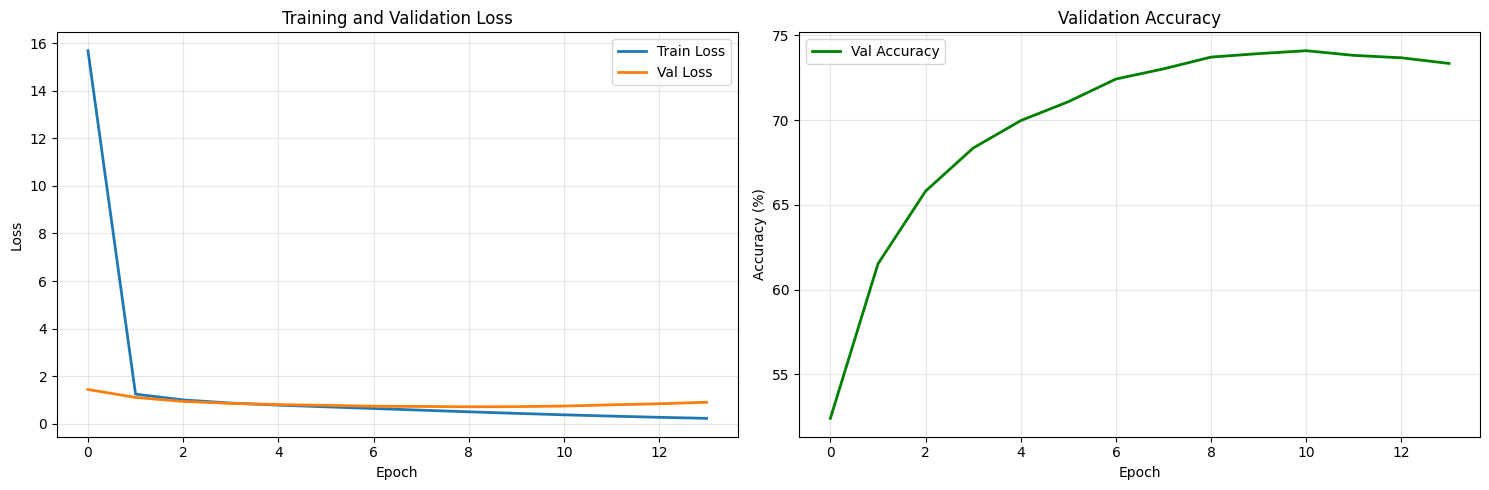

In [7]:
model = TinyRecursiveModel(config)

print(torch.sigmoid(model.latent_gate).item())

trainer = TRMTrainer(model, config)

trainer.train(train_loader, val_loader)

trainer.plot_training_history()


Model loaded from checkpoints/trm_sudoku_best.pt

Testing on validation examples:

Example 1 - Accuracy: 74.07%


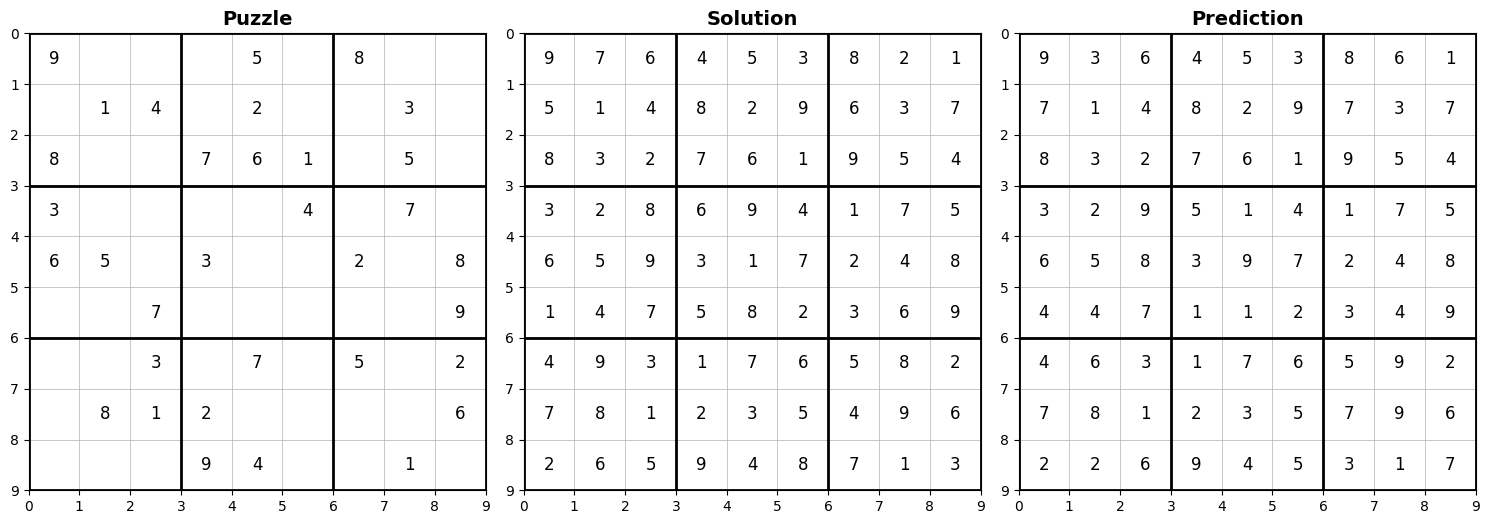


Example 2 - Accuracy: 75.31%


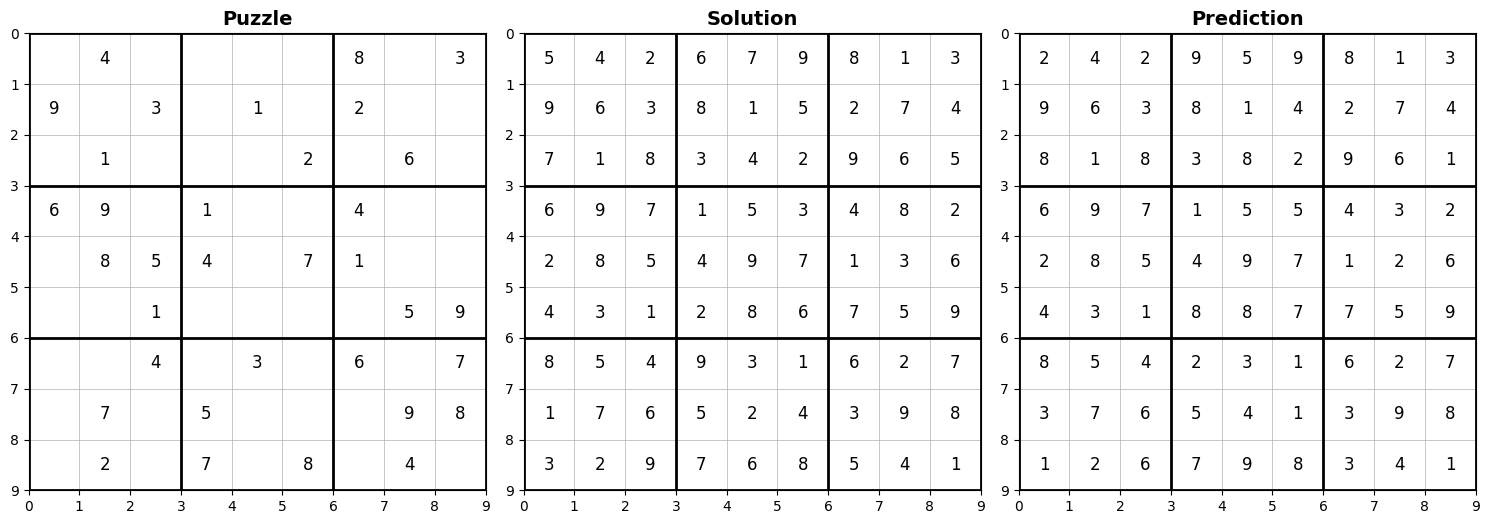


Example 3 - Accuracy: 66.67%


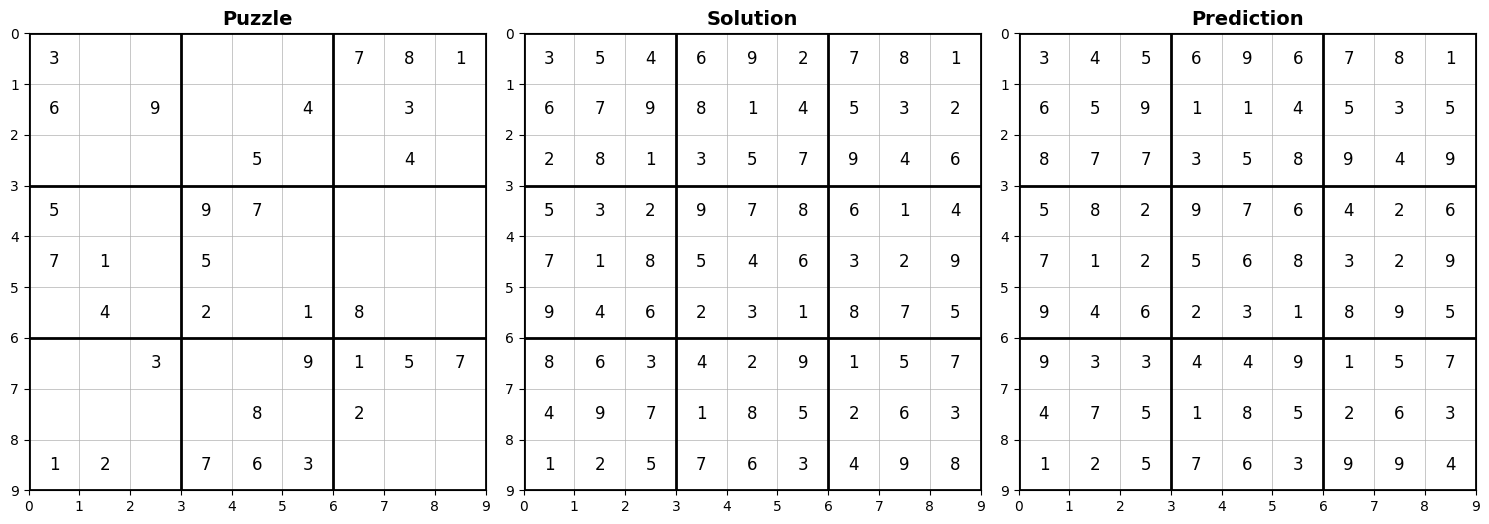

In [8]:
def load_model(checkpoint_path: str, config: TRMConfig):
    model = TinyRecursiveModel(config)
    checkpoint = torch.load(checkpoint_path, map_location=config.device, weights_only=False)
    model.load_state_dict(checkpoint['model_state_dict'])
    model = model.to(config.device)
    model.eval()
    print(f"Model loaded from {checkpoint_path}")
    return model

def predict_sudoku(model, quiz, config: TRMConfig):
    model.eval()

    quiz_onehot = np.zeros((81, 10), dtype=np.float32)
    for i, val in enumerate(quiz):
        quiz_onehot[i, val] = 1.0
    quiz_onehot = quiz_onehot.flatten()

    input_tensor = torch.FloatTensor(quiz_onehot).unsqueeze(0).to(config.device)

    with torch.no_grad():
        output = model(input_tensor)
        output = output.view(81, 9)
        prediction = torch.argmax(output, dim=-1).cpu().numpy() + 1

    return prediction

def visualize_sudoku(quiz, solution, prediction=None):
    fig, axes = plt.subplots(1, 3 if prediction is not None else 2, figsize=(15, 5))

    def draw_grid(ax, grid, title):
        ax.set_title(title, fontsize=14, fontweight='bold')
        ax.set_xlim(0, 9)
        ax.set_ylim(0, 9)
        ax.set_xticks(range(10))
        ax.set_yticks(range(10))
        ax.grid(True, linewidth=0.5)

        for i in range(0, 10, 3):
            ax.axhline(i, color='black', linewidth=2)
            ax.axvline(i, color='black', linewidth=2)

        grid_2d = grid.reshape(9, 9)
        for i in range(9):
            for j in range(9):
                if grid_2d[i, j] != 0:
                    ax.text(j + 0.5, 8.5 - i, str(grid_2d[i, j]),
                           ha='center', va='center', fontsize=12)

        ax.invert_yaxis()
        ax.set_aspect('equal')

    draw_grid(axes[0], quiz, "Puzzle")
    draw_grid(axes[1], solution, "Solution")
    if prediction is not None:
        draw_grid(axes[2], prediction, "Prediction")

    plt.tight_layout()
    plt.show()

model_path = os.path.join(config.save_dir, config.model_name)
if os.path.exists(model_path):
    trained_model = load_model(model_path, config)

    print("\nTesting on validation examples:")
    for i in range(3):
        idx = np.random.randint(0, len(val_dataset))
        quiz_onehot, solution_target = val_dataset[idx]

        quiz = dataset.quizzes[val_dataset.indices[idx]]
        solution = dataset.solutions[val_dataset.indices[idx]]

        prediction = predict_sudoku(trained_model, quiz, config)

        accuracy = (prediction == solution).mean() * 100
        print(f"\nExample {i+1} - Accuracy: {accuracy:.2f}%")

        visualize_sudoku(quiz, solution, prediction)
else:
    print(f"Model not found at {model_path}. Please train the model first.")

In [9]:
def save_production_model(model, config: TRMConfig, filename: str = "trm_sudoku_production.pt"):
    save_path = os.path.join(config.save_dir, filename)
    torch.save({
        'model_state_dict': model.state_dict(),
        'config': config
    }, save_path)
    print(f"\nProduction model saved to: {save_path}")
    print(f"Model size: {os.path.getsize(save_path) / 1024 / 1024:.2f} MB")
    return save_path

if os.path.exists(model_path):
    production_path = save_production_model(trained_model, config)
    print("\nModel ready for deployment!")
    print(f"  Load with: torch.load('{production_path}')")
else:
    print("Train the model first before saving for production.")


Production model saved to: checkpoints/trm_sudoku_production.pt
Model size: 51.11 MB

Model ready for deployment!
  Load with: torch.load('checkpoints/trm_sudoku_production.pt')
